<h1> Localization for pokemon <h1>

In [ ]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from imageio.v3 import imread
from matplotlib.patches import Rectangle
from skimage.transform import resize

##Loading Image

In [ ]:
!wget https://lazyprogrammer.me/course_files/charmander-tight.png

--2023-11-11 11:28:52--  https://lazyprogrammer.me/course_files/charmander-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3952 (3.9K) [image/png]
Saving to: ‘charmander-tight.png’

charmander-tight.pn 100%[===================>]   3.86K  --.-KB/s    in 0s      

2023-11-11 11:28:53 (63.8 MB/s) - ‘charmander-tight.png’ saved [3952/3952]



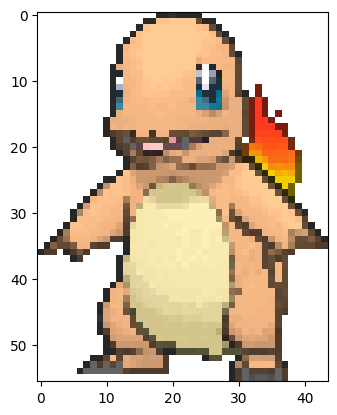

In [ ]:
pika = imread('charmander-tight.png')
plt.imshow(pika)

In [ ]:
print(type(pika))
print(pika.shape)

<class 'numpy.ndarray'>
(56, 44, 4)


## Create Model

In [ ]:
def create(lr=0.001):
  vgg = tf.keras.applications.VGG19(input_shape=[200, 200, 3], include_top=False, weights='imagenet')
  x = Flatten()(vgg.output)
  x = Dense(4, activation='sigmoid')(x)
  model = Model(vgg.input, x)
  model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=lr))
  return model

In [ ]:
pika = np.array(pika)
H, W, _ = pika.shape
SIZE = 200

## Localization

### Basic localization

In [ ]:
def pokemon_generator(batch_size=64):
  # generate image and targets
  while True:
    for _ in range(50):
      X = np.zeros((batch_size, SIZE, SIZE, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # choose location and store in target
        row0 = np.random.randint(SIZE - H)
        col0 = np.random.randint(SIZE - W)
        row1 = row0 + H
        col1 = col0 + W
        X[i,row0:row1,col0:col1,:] = pika[:,:,:3]
        Y[i,0] = row0/SIZE
        Y[i,1] = col0/SIZE

        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/SIZE
        Y[i,3] = (col1 - col0)/SIZE

      yield X / 255., Y

In [ ]:
def pokemon_prediction(model):
    # Generate a random image
    x = np.zeros((SIZE, SIZE, 3))
    row0 = np.random.randint(SIZE - H)
    col0 = np.random.randint(SIZE - W)
    row1 = row0 + H
    col1 = col0 + W
    x[row0:row1,col0:col1,:] = pika[:,:,:3]
    print("true:", row0, col0, row1, col1)

    # Predict
    X = np.expand_dims(x, 0) / 255.
    p = model.predict(X)[0]

    # Calculate target / loss
    y = np.zeros(4)
    y[0] = row0/SIZE
    y[1] = col0/SIZE
    y[2] = (row1 - row0)/SIZE
    y[3] = (col1 - col0)/SIZE

    # Draw the box
    row0 = int(p[0]*SIZE)
    col0 = int(p[1]*SIZE)
    row1 = int(row0 + p[2]*SIZE)
    col1 = int(col0 + p[3]*SIZE)
    print("pred:", row0, col0, row1, col1)
    print("loss:", -np.mean(y * np.log(p) + (1 - y)*np.log(1-p)))


    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    rect = Rectangle(
        (p[1]*SIZE, p[0]*SIZE),
        p[3]*SIZE, p[2]*SIZE,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

**main flow**

In [ ]:
model = create()
model.fit(pokemon_generator(), steps_per_epoch=50, epochs=5)

80134624/80134624 [==============================] - 4s 0us/step
Epoch 1/5
50/50 [==============================] - 72s 765ms/step - loss: 1.6453
Epoch 2/5
50/50 [==============================] - 37s 745ms/step - loss: 0.5853
Epoch 3/5
50/50 [==============================] - 37s 745ms/step - loss: 0.5605
Epoch 4/5
50/50 [==============================] - 37s 748ms/step - loss: 0.5590
Epoch 5/5
50/50 [==============================] - 37s 747ms/step - loss: 0.5540


true: 97 105 153 149
1/1 [==============================] - 1s 985ms/step
pred: 103 107 160 149
loss: 0.6267571857571601


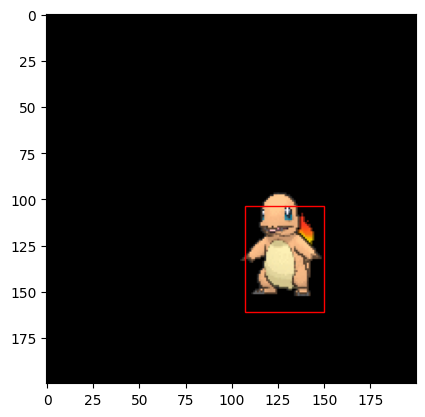

In [ ]:
pokemon_prediction(model)

###Changing sizes of Pokemon and predict<h1>

In [ ]:
# resize object generator
def pokemon_generator_with_resize(batch_size=64):
  # generate image and targets
  while True:
    for _ in range(50):
      X = np.zeros((batch_size, SIZE, SIZE, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # resize charmander - make it bigger or smaller
        scale = 0.5 + np.random.random() # [0.5, 1.5]
        new_height = int(H * scale)
        new_width = int(W * scale)
        obj = resize(pika, (new_height, new_width), preserve_range=True).astype(np.uint8) # keep it from 0..255

        # choose location and store in target
        row0 = np.random.randint(SIZE - new_height)
        col0 = np.random.randint(SIZE - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width
        X[i,row0:row1,col0:col1,:] = obj[:,:,:3]
        Y[i,0] = row0/SIZE
        Y[i,1] = col0/SIZE

        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/SIZE
        Y[i,3] = (col1 - col0)/SIZE

      yield X/255., Y

In [ ]:
# predict resize
def pokemon_prediction_with_resize(model):
    # resize charmander - make it bigger or smaller
    scale = 0.5 + np.random.random()
    new_height = int(H * scale)
    new_width = int(W * scale)
    obj = resize(pika, (new_height, new_width), preserve_range=True).astype(np.uint8) # keep it from 0..255

    # Generate a random image
    x = np.zeros((SIZE, SIZE, 3))
    row0 = np.random.randint(SIZE - new_height)
    col0 = np.random.randint(SIZE - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width
    x[row0:row1,col0:col1,:] = obj[:,:,:3]
    print("true:", row0, col0, row1, col1)

    # Predict
    X = np.expand_dims(x, 0) / 255.
    p = model.predict(X)[0]

    # Draw the box
    row0 = int(p[0]*SIZE)
    col0 = int(p[1]*SIZE)
    row1 = int(row0 + p[2]*SIZE)
    col1 = int(col0 + p[3]*SIZE)
    print("pred:", row0, col0, row1, col1)

    y = np.zeros(4)
    y[0] = row0/SIZE
    y[1] = col0/SIZE
    y[2] = (row1 - row0)/SIZE
    y[3] = (col1 - col0)/SIZE
    print("loss:", -np.mean(y * np.log(p) + (1 - y)*np.log(1-p)))


    fig, ax = plt.subplots(1)
    ax.imshow(x.astype(np.uint8))
    rect = Rectangle(
        (p[1]*SIZE, p[0]*SIZE),
        p[3]*SIZE, p[2]*SIZE,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()

**resize main flow**

In [ ]:
model = create(lr=0.0001)
model.fit(pokemon_generator_with_resize(), steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 [==============================] - 44s 793ms/step - loss: 0.5538
Epoch 2/5
50/50 [==============================] - 39s 776ms/step - loss: 0.5443
Epoch 3/5
50/50 [==============================] - 39s 781ms/step - loss: 0.5439
Epoch 4/5
50/50 [==============================] - 39s 780ms/step - loss: 0.5453
Epoch 5/5
50/50 [==============================] - 39s 779ms/step - loss: 0.5433


true: 71 107 126 150
1/1 [==============================] - 0s 156ms/step
pred: 70 106 125 149
loss: 0.6118890165910125


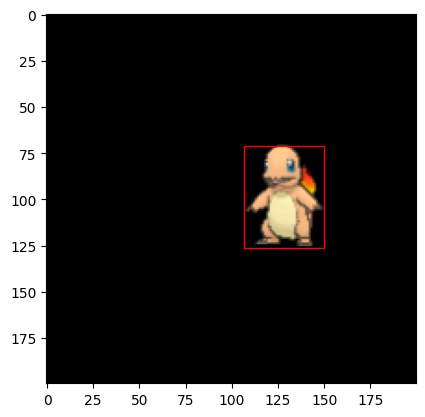

In [ ]:
pokemon_prediction_with_resize(model)

### Flip Object

In [ ]:
def pokemon_generator_flip(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, SIZE, SIZE, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # make the circles and store their location in target
        row0 = np.random.randint(SIZE - H)
        col0 = np.random.randint(SIZE - W)
        row1 = row0 + H
        col1 = col0 + W

        # maybe flip
        if np.random.random() < 0.5:
          obj = np.fliplr(pika)
        else:
          obj = pika

        X[i,row0:row1,col0:col1,:] = obj[:,:,:3]
        Y[i,0] = row0/SIZE
        Y[i,1] = col0/SIZE

        # later: make the pokemon different sizes
        Y[i,2] = (row1 - row0)/SIZE
        Y[i,3] = (col1 - col0)/SIZE

      yield X / 255., Y

In [ ]:
def pokemon_prediction_flip(model):
  # Generate a random image
  x = np.zeros((SIZE, SIZE, 3))
  row0 = np.random.randint(SIZE - H)
  col0 = np.random.randint(SIZE - W)
  row1 = row0 + H
  col1 = col0 + W

  # maybe flip
  if np.random.random() < 0.5:
    obj = np.fliplr(pika)
  else:
    obj = pika

  x[row0:row1,col0:col1,:] = obj[:,:,:3]
  print("true:", row0, col0, row1, col1)

  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  # Draw the box
  row0 = int(p[0]*SIZE)
  col0 = int(p[1]*SIZE)
  row1 = int(row0 + p[2]*SIZE)
  col1 = int(col0 + p[3]*SIZE)
  print("pred:", row0, col0, row1, col1)

  y = np.zeros(4)
  y[0] = row0/SIZE
  y[1] = col0/SIZE
  y[2] = (row1 - row0)/SIZE
  y[3] = (col1 - col0)/SIZE
  print("loss:", -np.mean(y * np.log(p) + (1 - y)*np.log(1-p)))


  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*SIZE, p[0]*SIZE),
      p[3]*SIZE, p[2]*SIZE,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

**flip main flow**

In [ ]:
model = create()
model.fit(pokemon_generator_flip(), steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 [==============================] - 42s 755ms/step - loss: 1.6912
Epoch 2/5
50/50 [==============================] - 37s 750ms/step - loss: 0.5585
Epoch 3/5
50/50 [==============================] - 37s 750ms/step - loss: 0.5540
Epoch 4/5
50/50 [==============================] - 38s 750ms/step - loss: 0.5539
Epoch 5/5
50/50 [==============================] - 37s 750ms/step - loss: 0.5553


true: 105 47 161 91
1/1 [==============================] - 0s 262ms/step
pred: 104 47 160 90
loss: 0.5877697820775211


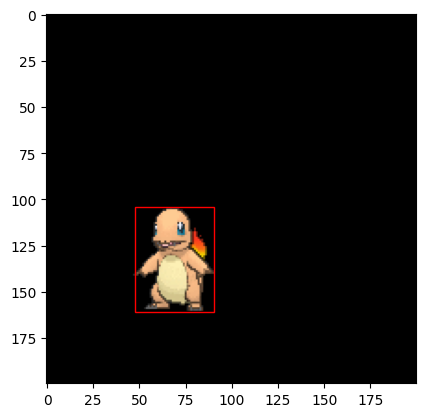

In [ ]:
pokemon_prediction_flip(model)

<h1> Adding Background </h1>

download some background images

In [ ]:
!wget https://lazyprogrammer.me/course_files/backgrounds.zip

--2023-11-11 11:40:04--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K   401KB/s    in 1.2s    

2023-11-11 11:40:06 (401 KB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [ ]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

In [ ]:
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # Note: they may not all be the same size
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

In [ ]:
def pokemon_generator_bg(batch_size=64):
  # generate image and targets
  while True:
    for _ in range(50):
      X = np.zeros((batch_size, SIZE, SIZE, 3))
      Y = np.zeros((batch_size, 4))

      for i in range(batch_size):
        # select a random background for charmander
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - SIZE)
        rnd_w = np.random.randint(bg_w - SIZE)
        X[i] = bg[rnd_h:rnd_h+SIZE,rnd_w:rnd_w+SIZE].copy()

        # resize charmander - make it bigger or smaller
        scale = 0.5 + np.random.random()
        new_height = int(H * scale)
        new_width = int(W * scale)
        obj = resize(pika,  (new_height, new_width), preserve_range=True).astype(np.uint8) # keep it from 0..255

        # maybe flip
        if np.random.random() < 0.5:
          obj = np.fliplr(obj)

        # choose a random location to store the object
        row0 = np.random.randint(SIZE - new_height)
        col0 = np.random.randint(SIZE - new_width)
        row1 = row0 + new_height
        col1 = col0 + new_width

        # can't 'just' assign obj to a slice of X
        # since the transparent parts will be black (0)

        mask = (obj[:,:,3] == 0) # find where the pokemon is 0
        bg_slice = X[i,row0:row1,col0:col1,:] # where we want to place `obj`
        bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
        bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
        X[i,row0:row1,col0:col1,:] = bg_slice # put the slice back

        # make targets - set lables
        Y[i,0] = row0/SIZE
        Y[i,1] = col0/SIZE

        # make the pokemon different sizes
        Y[i,2] = (row1 - row0)/SIZE
        Y[i,3] = (col1 - col0)/SIZE

      yield X / 255., Y


In [ ]:
def pokemon_prediction_bg(model):
  # select a random background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - SIZE)
  rnd_w = np.random.randint(bg_w - SIZE)
  x = bg[rnd_h:rnd_h+SIZE,rnd_w:rnd_w+SIZE].copy()

  # resize charmander - make it bigger or smaller
  scale = 0.5 + np.random.random()
  new_height = int(H * scale)
  new_width = int(W * scale)
  obj = resize(pika, (new_height, new_width), preserve_range=True).astype(np.uint8) # keep it from 0..255

  # maybe flip
  if np.random.random() < 0.5:
    obj = np.fliplr(obj)

  # choose a random location to store the object
  row0 = np.random.randint(SIZE - new_height)
  col0 = np.random.randint(SIZE - new_width)
  row1 = row0 + new_height
  col1 = col0 + new_width

  # can't 'just' assign obj to a slice of X
  # since the transparent parts will be black (0)

  mask = (obj[:,:,3] == 0) # find where the pokemon is 0
  bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
  bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
  bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
  x[row0:row1,col0:col1,:] = bg_slice # put the slice back
  print("true:", row0, col0, row1, col1)

  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]

  # Draw the box
  row0 = int(p[0]*SIZE)
  col0 = int(p[1]*SIZE)
  row1 = int(row0 + p[2]*SIZE)
  col1 = int(col0 + p[3]*SIZE)
  print("pred:", row0, col0, row1, col1)

  y = np.zeros(4)
  y[0] = row0/SIZE
  y[1] = col0/SIZE
  y[2] = (row1 - row0)/SIZE
  y[3] = (col1 - col0)/SIZE
  print("loss:", -np.mean(y * np.log(p) + (1 - y)*np.log(1-p)))

  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  rect = Rectangle(
      (p[1]*SIZE, p[0]*SIZE),
      p[3]*SIZE, p[2]*SIZE,linewidth=1,edgecolor='r',facecolor='none')
  ax.add_patch(rect)
  plt.show()

In [ ]:
model = create(lr=0.0001)
model.fit(pokemon_generator_bg(), steps_per_epoch=50, epochs=5)

Epoch 1/5
50/50 [==============================] - 45s 819ms/step - loss: 0.5732
Epoch 2/5
50/50 [==============================] - 41s 811ms/step - loss: 0.5434
Epoch 3/5
50/50 [==============================] - 41s 814ms/step - loss: 0.5455
Epoch 4/5
50/50 [==============================] - 41s 815ms/step - loss: 0.5416
Epoch 5/5
50/50 [==============================] - 41s 811ms/step - loss: 0.5451


true: 16 53 97 116
1/1 [==============================] - 0s 150ms/step
pred: 17 51 95 111
loss: 0.5345542169827968


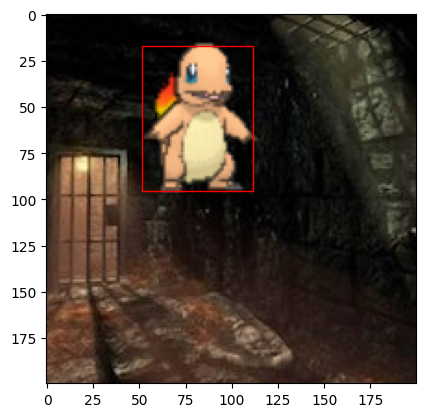

In [ ]:
pokemon_prediction_bg(model)